# Proyek Klasifikasi Gambar: Animals-10
- **Nama:** Cinta Izmy Fadilla
- **Email:** b25b8m104@student.devacademy.id
- **ID Dicoding:** b25b8m104

## Import Semua Packages/Library yang Digunakan

In [25]:
!pip install split-folders tensorflowjs --upgrade

# Sistem & utilitas
import os, glob, shutil, random

# Manipulasi data
import numpy as np
import pandas as pd

# Visualisasi
import matplotlib.pyplot as plt

# Gambar
from PIL import Image

# DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Dataset split
import splitfolders

# TensorFlow.js converter
import tensorflowjs as tfjs

# Google Drive
from google.colab import drive

# Untuk inference gambar
from tensorflow.keras.preprocessing import image

## Data Preparation

### Data Loading

In [8]:
drive.mount('/content/drive', force_remount=True)

DATASET_DIR = "/content/drive/MyDrive/raw img"

# Cek isi folder dataset
print("Isi folder dataset:")
for nama_folder in os.listdir(DATASET_DIR):
    path = os.path.join(DATASET_DIR, nama_folder)
    if os.path.isdir(path):
        print("-", nama_folder, ":", len(os.listdir(path)), "file")

Mounted at /content/drive
Isi folder dataset:
- chicken : 3098 file
- spider : 4821 file
- dog : 4863 file
- horse : 2623 file


### Data Preprocessing

#### Split Dataset

In [9]:
SPLIT_DIR = "/content/dataset_split"

if os.path.exists(SPLIT_DIR):
    shutil.rmtree(SPLIT_DIR)

splitfolders.ratio(
    DATASET_DIR,
    output=SPLIT_DIR,
    seed=42,
    ratio=(0.7, 0.15, 0.15)  # train/val/test
)

print("Sukses split dataset ke:", SPLIT_DIR)
print("Isi folder hasil split:")
for subdir in os.listdir(SPLIT_DIR):
    path = os.path.join(SPLIT_DIR, subdir)
    print("-", subdir)
    for kelas in os.listdir(path):
        print("   ", kelas, ":", len(os.listdir(os.path.join(path, kelas))))

Copying files: 15405 files [04:53, 52.56 files/s] 

Sukses split dataset ke: /content/dataset_split
Isi folder hasil split:
- val
    horse : 393
    dog : 729
    chicken : 464
    spider : 723
- train
    horse : 1836
    dog : 3404
    chicken : 2168
    spider : 3374
- test
    horse : 394
    dog : 730
    chicken : 466
    spider : 724


In [12]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

train_dir = f"{SPLIT_DIR}/train"
val_dir   = f"{SPLIT_DIR}/val"
test_dir  = f"{SPLIT_DIR}/test"

train_ds = image_dataset_from_directory(
    train_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int"
)
val_ds = image_dataset_from_directory(
    val_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int"
)
test_ds = image_dataset_from_directory(
    test_dir, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int", shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names, "Total classes:", num_classes)

# Optimisasi
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

Found 10782 files belonging to 4 classes.
Found 2309 files belonging to 4 classes.
Found 2314 files belonging to 4 classes.
Classes: ['chicken', 'dog', 'horse', 'spider'] Total classes: 4


## Modelling

In [13]:
# Normalisasi & Augmentasi
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])
normalizer = layers.Rescaling(1./255)

# Arsitektur CNN
input_shape = (*IMG_SIZE, 3)

model = Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,
    normalizer,

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
# Simpan model terbaik sementara
ckpt_path = "/content/best_model.keras"

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4482 - loss: 1.2939
Epoch 1: val_accuracy improved from -inf to 0.42573, saving model to /content/best_model.keras
337/337 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - accuracy: 0.4485 - loss: 1.2935 - val_accuracy: 0.4257 - val_loss: 2.0895 - learning_rate: 0.0010
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6401 - loss: 0.8886
Epoch 2: val_accuracy improved from 0.42573 to 0.64357, saving model to /content/best_model.keras
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - accuracy: 0.6402 - loss: 0.8885 - val_accuracy: 0.6436 - val_loss: 0.8767 - learning_rate: 0.0010
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7343 - loss: 0.7022
Epoch 3: val_accuracy did not improve from 0.64357
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - accuracy: 0.7343 - loss: 0.7022 - val_accuracy: 0.5427 - val_loss: 1.1504 - learning_rate: 0.0010
Epoch 4/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accu

In [15]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    initial_epoch=20,
    callbacks=callbacks
)

Epoch 21/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9017 - loss: 0.2584
Epoch 21: val_accuracy did not improve from 0.87787
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.9017 - loss: 0.2584 - val_accuracy: 0.7934 - val_loss: 0.5823 - learning_rate: 5.0000e-04
Epoch 22/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9086 - loss: 0.2515
Epoch 22: val_accuracy did not improve from 0.87787
337/337 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.9086 - loss: 0.2515 - val_accuracy: 0.8354 - val_loss: 0.4736 - learning_rate: 5.0000e-04
Epoch 23/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9208 - loss: 0.2196
Epoch 23: val_accuracy did not improve from 0.87787
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.9207 - loss: 0.2197 - val_accuracy: 0.8038 - val_loss: 0.5531 - learning_rate: 5.0000e-04
Epoch 24/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9159 - loss: 0.2324
Epoch 24: val_accuracy did not improve from 

In [16]:
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    initial_epoch=30,
    callbacks=callbacks
)

Epoch 31/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9406 - loss: 0.1716
Epoch 31: val_accuracy did not improve from 0.90732
337/337 ━━━━━━━━━━━━━━━━━━━━ 47s 140ms/step - accuracy: 0.9406 - loss: 0.1716 - val_accuracy: 0.8900 - val_loss: 0.3316 - learning_rate: 1.2500e-04
Epoch 32/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9393 - loss: 0.1641
Epoch 32: val_accuracy improved from 0.90732 to 0.90819, saving model to /content/best_model.keras
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 132ms/step - accuracy: 0.9393 - loss: 0.1641 - val_accuracy: 0.9082 - val_loss: 0.2921 - learning_rate: 1.2500e-04
Epoch 33/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9459 - loss: 0.1528
Epoch 33: val_accuracy did not improve from 0.90819
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.9459 - loss: 0.1528 - val_accuracy: 0.8956 - val_loss: 0.3133 - learning_rate: 1.2500e-04
Epoch 34/40
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9430 - loss: 0.15

## Evaluasi dan Visualisasi

In [18]:
ckpt_path = "/content/best_model.keras"

model.load_weights(ckpt_path)

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"[BEST WEIGHTS] Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

[BEST WEIGHTS] Test Accuracy: 88.85% | Test Loss: 0.3388


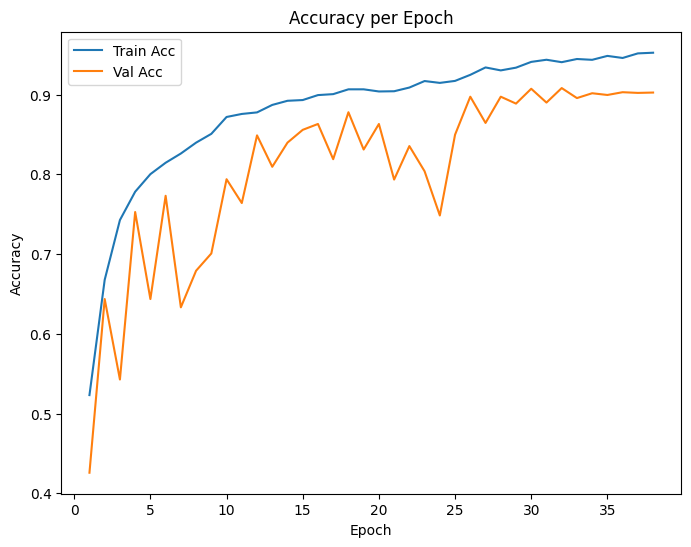

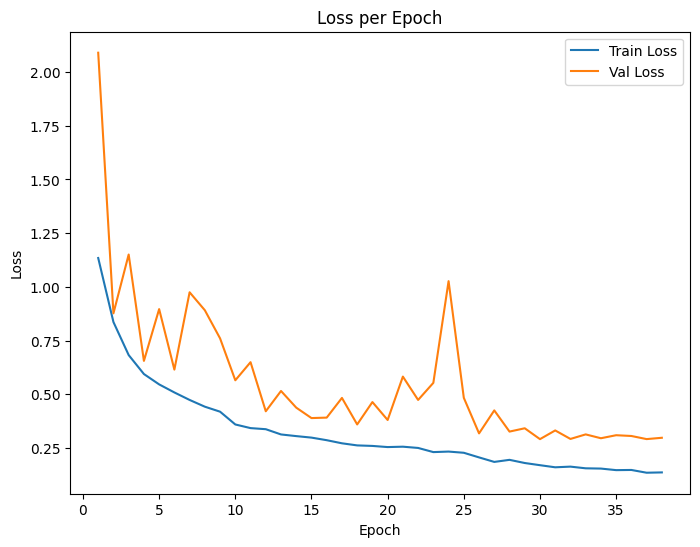

In [19]:
all_acc = history.history['accuracy']
all_val_acc = history.history['val_accuracy']
all_loss = history.history['loss']
all_val_loss = history.history['val_loss']

for h in [history2, history3]:
    if h is not None:
        all_acc += h.history['accuracy']
        all_val_acc += h.history['val_accuracy']
        all_loss += h.history['loss']
        all_val_loss += h.history['val_loss']

epochs_range = range(1, len(all_acc)+1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, all_acc, label='Train Acc')
plt.plot(epochs_range, all_val_acc, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy per Epoch')
plt.legend(); plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, all_loss, label='Train Loss')
plt.plot(epochs_range, all_val_loss, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss per Epoch')
plt.legend(); plt.show()

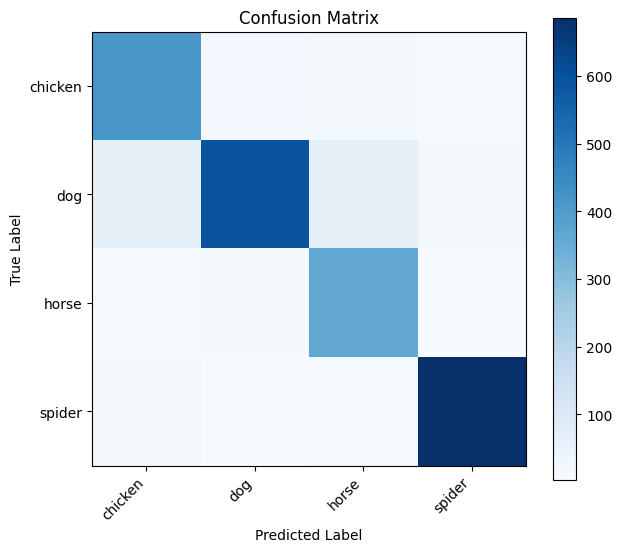

In [20]:
y_true = []
y_pred = []

for batch, labels in test_ds:
    preds = model.predict(batch, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(class_names)).numpy()

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Konversi Model

In [23]:
# Folder output
BASE_OUT        = "/content/submission"
SAVED_MODEL_DIR = f"{BASE_OUT}/saved_model"
TFLITE_DIR      = f"{BASE_OUT}/tflite"
TFJS_DIR        = f"{BASE_OUT}/tfjs_model"

os.makedirs(SAVED_MODEL_DIR, exist_ok=True)
os.makedirs(TFLITE_DIR, exist_ok=True)
os.makedirs(TFJS_DIR, exist_ok=True)

# Simpan SavedModel
model.export(SAVED_MODEL_DIR)
print("SavedModel ->", SAVED_MODEL_DIR)

model_no_aug = tf.keras.Sequential(model.layers[1:])
model_no_aug.build((None, 224, 224, 3))

# Export clean model
clean_model_dir = f"{BASE_OUT}/saved_model_clean"
model_no_aug.export(clean_model_dir)

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(clean_model_dir)
tflite_model = converter.convert()

tflite_path = f"{TFLITE_DIR}/model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

# Simpan label.txt untuk TFLite
with open(f"{TFLITE_DIR}/label.txt", "w") as f:
    for c in class_names:
        f.write(c + "\n")

print("TF-Lite ->", tflite_path)

# Simpan TFJS
tfjs.converters.save_keras_model(model_no_aug, TFJS_DIR)
print("TFJS ->", TFJS_DIR)

Saved artifact at '/content/submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137834296175760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273343440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273344208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273346704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273347472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273346896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273348624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273348432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273349200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137834273349968: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

TF-Lite -> /content/submission/tflite/model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
TFJS -> /content/submission/tfjs_model


## Inference (Optional)

Pakai gambar: /content/dataset_split/test/spider/OIP-De_ZhXuB3MVTsFc0YS0RFQHaE7.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


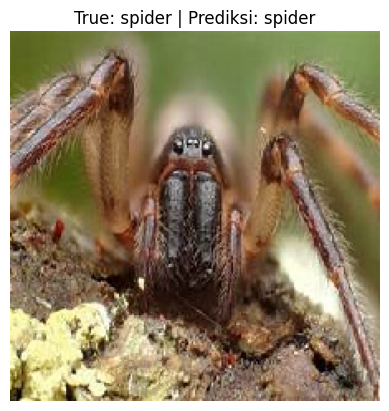

In [30]:
# Ambil 1 gambar random dari folder test
random_class = random.choice(class_names)
test_dir = f"{SPLIT_DIR}/test/{random_class}"
sample_image_path = random.choice(glob.glob(test_dir + "/*"))

print("Pakai gambar:", sample_image_path)

# Load & preprocess
img = image.load_img(sample_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Prediksi pakai model SavedModel
preds = model.predict(img_array)
pred_class = np.argmax(preds, axis=1)[0]

# Tampilkan gambar + hasil prediksi
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {random_class} | Prediksi: {class_names[pred_class]}")
plt.show()

In [32]:
pip freeze requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.15
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.16.5
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.10.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.3.0
arviz==0.22.0
astropy==7.1.0
astropy-iers-data==0.2025.9.15.0.37.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
Authlib==1.6.4
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.21.0
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.21.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.8.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.8.3
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.3
chex==0.1.90
clara